# Posterior uncertainties of the ODE filter

We investigate the uncertaintes returned by Gaussian ODE Filters and how they are affected by the choice of diffusion model.


In [1]:
# Make inline plots vector graphics instead of raster graphics
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

# Plotting
import matplotlib.pyplot as plt
plt.style.use('../../probnum.mplstyle')

In [2]:
import numpy as np

from probnum.diffeq import probsolve_ivp


rng = np.random.default_rng(seed=123)

We start with the Lotka-Volterra equations.

In [3]:

def f(t, y):
    y1, y2 = y
    return np.array([0.5 * y1 - 0.05 * y1 * y2, -0.5 * y2 + 0.05 * y1 * y2])

def df(t, y):
    y1, y2 = y
    return np.array([[0.5 - 0.05 * y2, -0.05 * y1], [0.05 * y2, -0.5 + 0.05 * y1]])

t0 = 0.
tmax = 20.
y0 = np.array([20, 20])

The EK0 ODE filter is quite fast and flexible, but does not yield accurate uncertainty estimates. We see below that the uncertainty increases monotonously, independent on the actual peaks and valleys of the ODE solution.

It is not surprising that the EK0 solution is agnostic of the trajectory. In fact, the covariance of the EK0 filter is independent of the data and as such, we cannot expect it to return useful uncertainty.

In [4]:
sol = probsolve_ivp(f, t0, tmax, y0, df=df, step=0.1, adaptive=False, diffusion_model="dynamic")

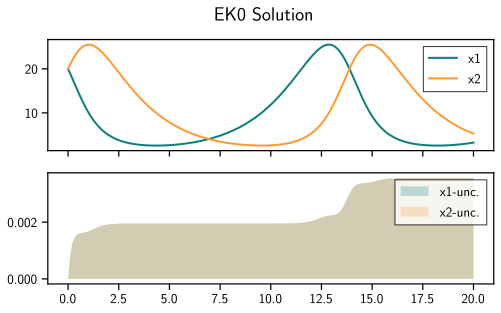

In [5]:
means, stds = sol.states.mean, sol.states.std

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1.plot(sol.locations, means[:, 0], label="x1")
ax1.plot(sol.locations, means[:, 1], label="x2")
ax1.legend()
ax2.fill_between(sol.locations, stds[:, 0], alpha=0.25, label="x1-unc.")
ax2.fill_between(sol.locations, stds[:, 1], alpha=0.25, label="x2-unc.")
ax2.legend()
fig.suptitle("EK0 Solution")
plt.show()

Notice that the uncertainties are aware of the peaks and valleys. They even know whether the peak is flat (rhs of blue, lhs of orange; smaller ones of the blue peaks) or steep. On top of that, they increase over time.

For both we can also sample from the solution. Let us compute a low-res solution (so the samples actually look different from each other).

Beware, because large numbers of samples can take a long time to compute.

In [6]:
sol = probsolve_ivp(f, t0, tmax, y0, df=df, step=0.5, algo_order=1, adaptive=False, diffusion_model="dynamic")

In [7]:
# sol.kalman_posterior.diffusion_model.diffusions[2:8] *= 100000

In [8]:
num_samples = 150
locations = np.arange(0., 22.1, 0.05)
locations = sol.locations
samples = sol.sample(rng=rng, t=locations, size=num_samples)

solution = sol(locations)
means = solution.mean
stds = solution.std

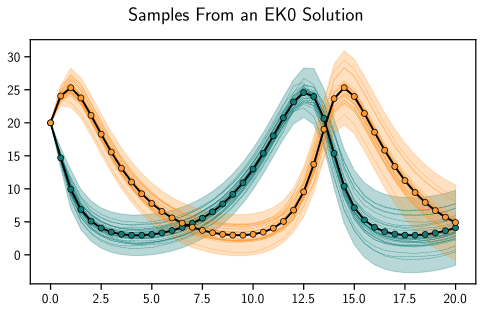

In [9]:
fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True)
for sample in samples[::5]:
    ax1.plot(locations, sample[:, 0], ":", color="C0", linewidth=0.5, alpha=1)
    ax1.plot(locations, sample[:, 1], ":", color="C1", linewidth=0.5, alpha=1)
ax1.plot(locations, means[:, 0], label="x1", color="k")
ax1.plot(locations, means[:, 1], label="x2", color="k")
ax1.fill_between(
    locations,
    means[:, 0] - 3 * stds[:, 0],
    means[:, 0] + 3 * stds[:, 0],
    color="C0",
    alpha=0.3,
)
ax1.fill_between(
    locations,
    means[:, 1] - 3 * stds[:, 1],
    means[:, 1] + 3 * stds[:, 1],
    color="C1",
    alpha=0.3,
)

ax1.plot(sol.locations, sol.states.mean, "o")
fig.suptitle(f"Samples From an EK0 Solution")

plt.show()

Let us have a look at the inferred diffusion model

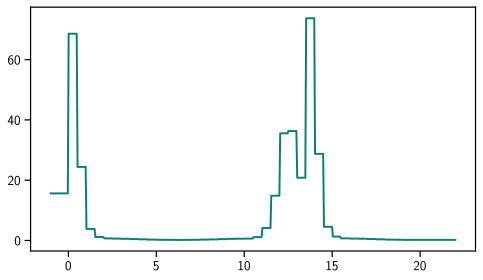

In [10]:
x = np.linspace(-1, 22, 500)
plt.plot(x, sol.kalman_posterior.diffusion_model(x))
plt.show()

How well do the empirical moments of the samples reflect the uncertainty of the dense output?

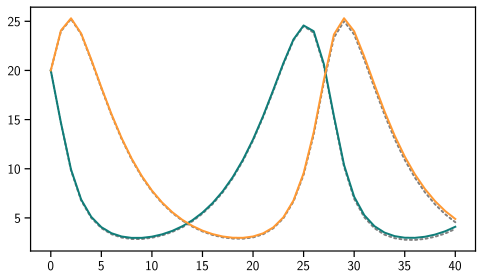

In [11]:
plt.plot(samples.mean(axis=0), color="gray", linestyle="dotted")
plt.plot(means)
plt.show()

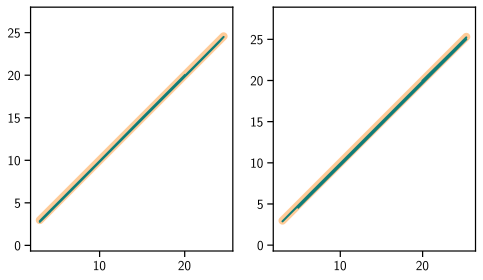

In [12]:
sample_mean = samples.mean(axis=0)
sample_std = samples.std(axis=0)

fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.plot(means[:, 0], sample_mean[:, 0])
ax2.plot(means[:, 1], sample_mean[:, 1])
ax1.plot(means[:, 0], means[:, 0], alpha=0.5, linewidth=8, zorder=0)
ax2.plot(means[:, 1], means[:, 1], alpha=0.5, linewidth=8, zorder=0)

ax1.axis("equal")
ax2.axis("equal")
plt.show()

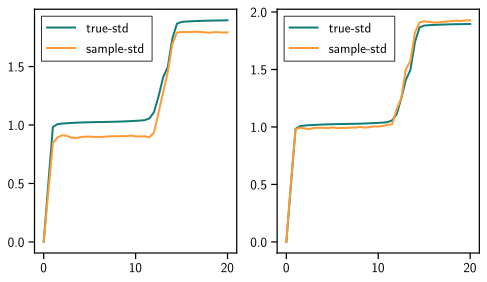

In [13]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.plot(locations, stds[:, 0], label="true-std")
ax1.plot(locations, sample_std[:, 0], label="sample-std")
ax1.legend()
ax2.plot(locations, stds[:, 1], label="true-std")
ax2.plot(locations, sample_std[:, 1], label="sample-std")
ax2.legend()
plt.show()

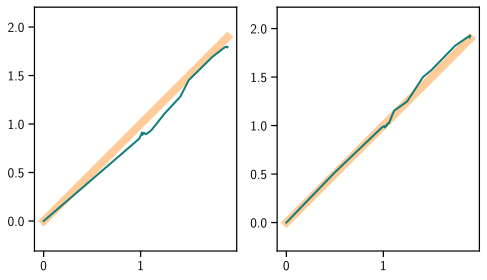

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

ax1.plot(stds[:, 0], sample_std[:, 0])
ax2.plot(stds[:, 1], sample_std[:, 1])
ax1.plot(stds[:, 0], stds[:, 0], alpha=0.5, linewidth=8, zorder=0)
ax2.plot(stds[:, 1], stds[:, 1], alpha=0.5, linewidth=8, zorder=0)
ax1.axis("equal")
ax2.axis("equal")
plt.show()